# 线性回归从零开始实现

我们将从零开始实现整个方法，包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

In [27]:
import random
import torch
from d2l import torch as d2l

根据带有噪声的线性模型构造一个人造数据集。我们使用线性模型参数$w=[2, -3.4]^T$、$b=4.2$和噪声项$\epsilon$生成数据集及其标签：
$$
y = Xw + b + c
$$
可以将`c`视为模型预测和标签时的潜在观测误差。为了简化问题，我们将标准差设为0.01

In [28]:
def synthetic_data(w, b , num_examples):
    """生成 y = wx + b + 噪声"""    
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))
true_w = torch.tensor([2, -3.4])
true_b = 4.2 
features, labels = synthetic_data(true_w, true_b, 1000)  

`features`中的每一行都包含一个二维数据样本，`labels`中每一行都包含一维标签值(一个标量)

In [29]:
print('features', features[0], '\nlabel:', labels[0])

features tensor([0.9020, 0.1771]) 
label: tensor([5.3972])


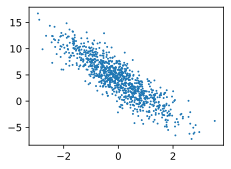

In [30]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)
# d2l.plt.scatter(features[:, 1].numpy(), labels.numpy(), 1)

定义一个`data_iter`函数，该函数接受批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量

In [31]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break


tensor([[ 1.3159,  1.5580],
        [ 1.7947,  0.0284],
        [ 0.9074, -0.3443],
        [ 0.4629, -1.5614],
        [-1.1953,  1.1409],
        [-0.2294, -0.6384],
        [-2.2445,  0.1443],
        [-0.3502,  1.2337],
        [ 1.2916, -0.3803],
        [ 0.4378, -2.1245]]) 
 tensor([[ 1.5266],
        [ 7.7080],
        [ 7.1812],
        [10.4311],
        [-2.0716],
        [ 5.9095],
        [-0.7745],
        [-0.6903],
        [ 8.0828],
        [12.2991]])


定义初始化模型参数

In [32]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

定义模型

In [33]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

定义损失函数

In [34]:
def squared_loss(y_hat, y):
    """均方误差"""
    # print("y_hat.shape", y.shape)
    # print("y.shape:", y.shape)
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2
    

定义优化算法

In [35]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

训练过程

In [36]:
from statistics import mean


lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  
        # X和y是小批量损失
        # 因为 l 的形状是(batch_size, 1)，而不是一个标量。l中的所有元素被加到一起
        # 并以此计算关于[w, b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch+1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.036339
epoch 2, loss 0.000129
epoch 3, loss 0.000045


In [37]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-1.6689e-06, -6.8617e-04], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0006], grad_fn=<RsubBackward1>)
